In [2]:
!nvidia-smi

Thu Sep  9 13:01:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.96       Driver Version: 471.96       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P0    24W /  N/A |    148MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, pipeline, GPTNeoForCausalLM, GPT2Tokenizer
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import csv
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("style_transfer.csv")
df.head()

,label,text
0,1,R.Kelly bout 50 ain't it ?
1,0,"R. Kelly's 50, right?"
2,1,I think Dominicans mean loud music loud takin...
3,0,Dominicans think loud music and good cooking
4,1,"If I offend u, u a pussy. So fuck u"


In [4]:
df.shape
df.info

<bound method DataFrame.info of       label                                               text
0         1                         R.Kelly bout 50 ain't it ?
1         0                              R. Kelly's 50, right?
2         1   I think Dominicans mean loud music loud takin...
3         0       Dominicans think loud music and good cooking
4         1                If I offend u, u a pussy. So fuck u
...     ...                                                ...
1995      0                                     I don't sleep.
1996      1                              Im finna go somewhere
1997      0          I'm going somewhere, I'm going somewhere.
1998      1                 I'm bored too man smh the struggle
1999      0                     I'm bored too, man, I'm bored.

[2000 rows x 2 columns]>

C:\Users\stwan\Miniconda3\envs\GPT_Dialect\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


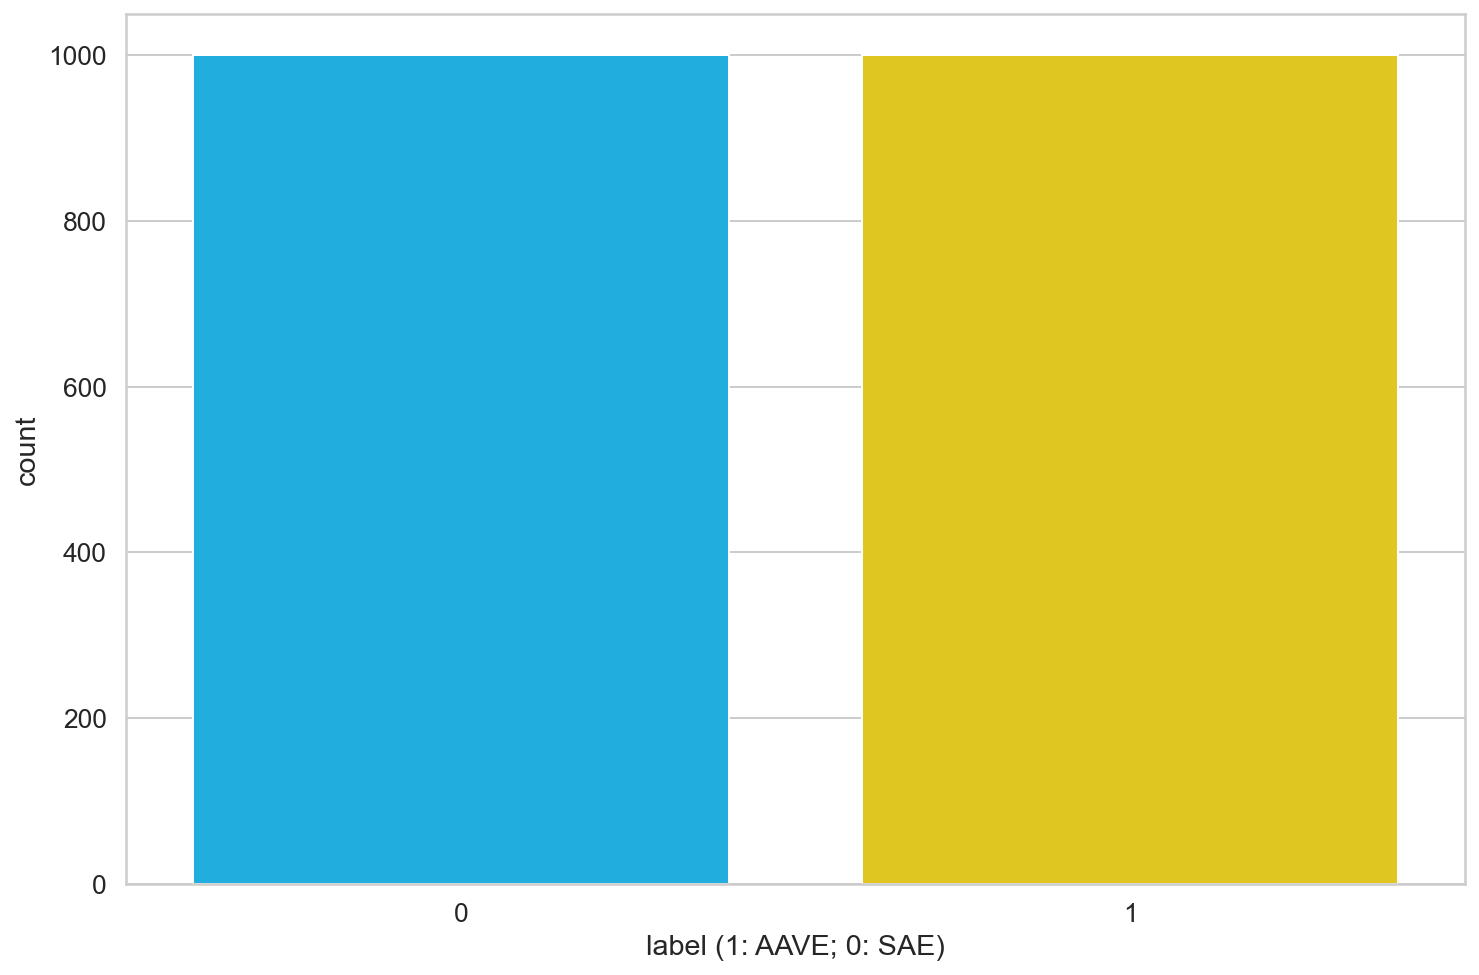

In [5]:
sns.countplot(df.label)
plt.xlabel('label (1: AAVE; 0: SAE)');

In [6]:
PRE_TRAINED_MODEL_NAME = 'EleutherAI/gpt-neo-1.3B'
tokenizer = GPT2Tokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = GPTNeoForCausalLM.from_pretrained(PRE_TRAINED_MODEL_NAME)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\stwan\Miniconda3\envs\GPT_Dialect\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


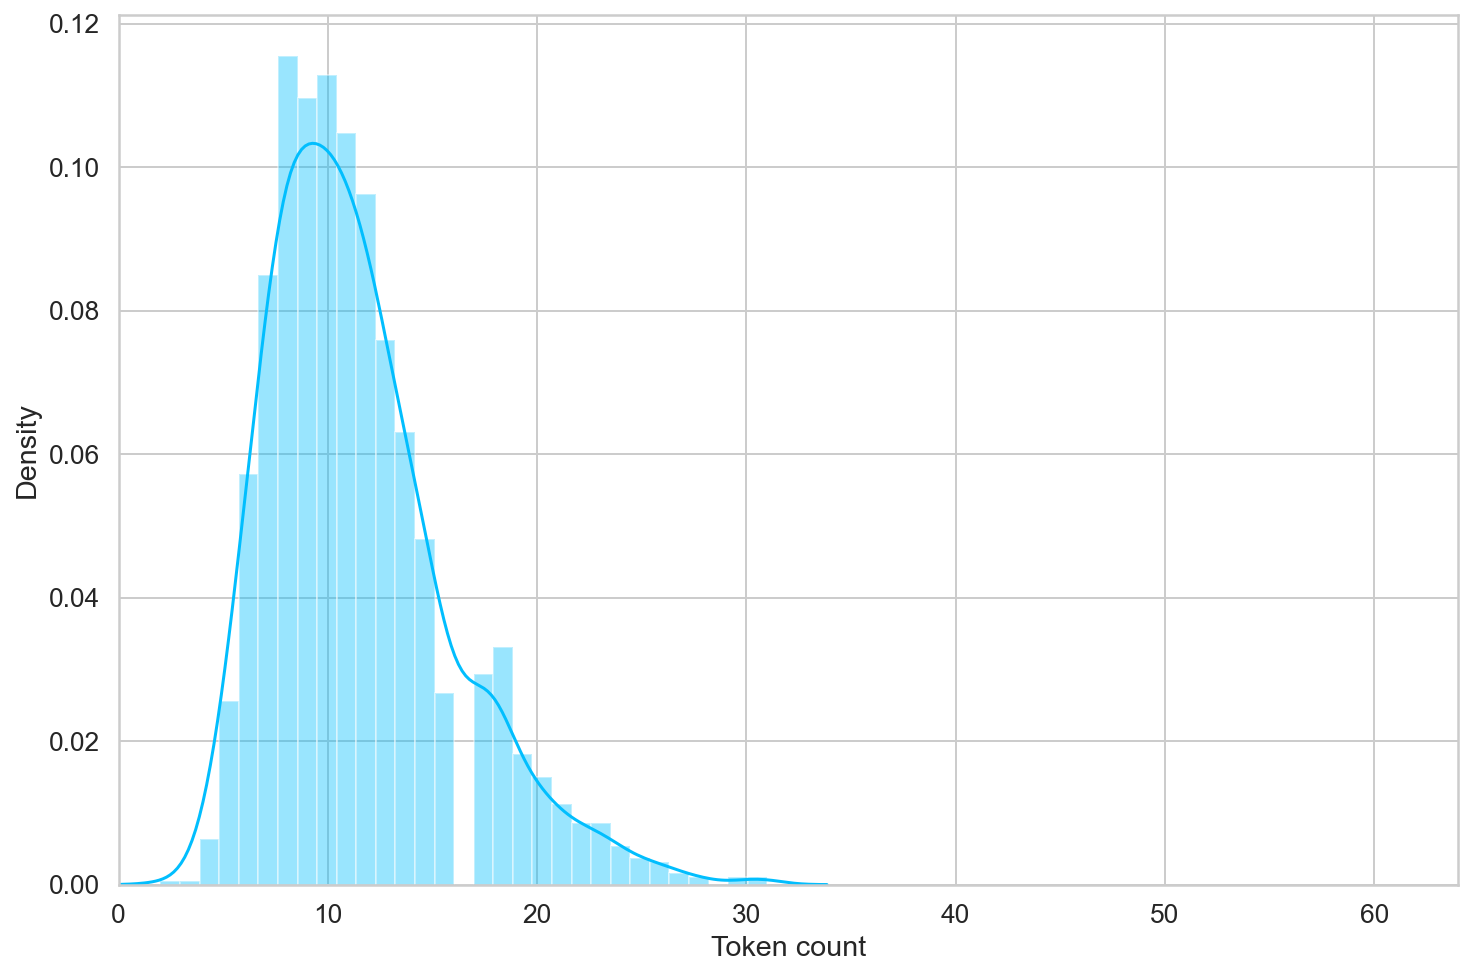

In [7]:
token_lens = []
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=256)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 64]);
plt.xlabel('Token count');

In [32]:
model.to("cuda:0")
with open('gen_txt.csv', 'a', encoding="utf-8") as f:
    writer = csv.writer(f)
    for i, txt in enumerate(tqdm(df.text)):
        input_ids = tokenizer(txt, return_tensors="pt").input_ids.cuda()
        gen_tokens = model.generate(input_ids, do_sample=True, max_length=30)
        gen_txt = tokenizer.batch_decode(gen_tokens)[0]
#         print([gen_txt])
        writer.writerow([i, gen_txt])

  3%|██▋                                                                             | 67/2000 [00:26<10:08,  3.18it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  4%|██▉                                                                             | 74/2000 [00:28<10:08,  3.16it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  7%|█████▎                                                                         | 134/2000 [00:50<11:37,  2.67it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 15%|███████████▊                                                                   | 298/2000 [01:55<11:37,  2.44it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_i